In [1]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import geoutils as gu
import xdem
from pprint import pprint
import altair as alt
from rasterio.enums import Resampling
import json 
import seaborn as sns

## Inputs

* Inputs are written in a JSON.
* The inputs file is specified by the `HSFM_GEOMORPH_INPUT_FILE` env var
* One input may be overriden with an additional env var - `RUN_LARGER_AREA`. If this env var is set to "yes" or "no" (exactly that string, it will be used. If the env var is not set, the params file is used to fill in this variable. If some other string is set, a failure is thrown).

If you use the arg, you must run from CLI like this

```
HSFM_GEOMORPH_INPUT_FILE='inputs/mazama_inputs.json' jupyter nbconvert --execute --to html dem-analysis/mt_baker_mass_wasted/xdem.ipynb  --output outputs/xdem_mazama.html
```

In [2]:
# Or set an env arg:
if os.environ.get('HSFM_GEOMORPH_INPUT_FILE'):
    json_file_path = os.environ['HSFM_GEOMORPH_INPUT_FILE']
else:
    json_file_path = 'inputs/coleman_inputs.json'

In [3]:
with open(json_file_path, 'r') as j:
     params = json.loads(j.read())

In [4]:
gully_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/gully.shp'
mwasting_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/mass_wasting.shp'
debutressing_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/debutressing.shp'

In [5]:
# Read inputs from params
valley_name = params['inputs']['valley_name']
TO_DROP = params['inputs']['TO_DROP']
TO_DROP_LARGER_AREA = params['inputs']['TO_DROP_LARGER_AREA']
TO_COREGISTER = params['inputs']['TO_COREGISTER']
SAVE_DDEMS = params['inputs']['SAVE_DDEMS']
EROSION_BY_DATE = params['inputs']['EROSION_BY_DATE']
INTERPOLATE = params['inputs']['INTERPOLATE']
FILTER_OUTLIERS = params['inputs']['FILTER_OUTLIERS']
glacier_polygons_file = params['inputs']['glacier_polygons_file']
dems_path = params['inputs']['dems_path']
valley_bounds_file = params['inputs']['valley_bounds_file']
strip_time_format = params['inputs']['strip_time_format']
plot_output_dir = params['inputs']['plot_output_dir']
uncertainty_file = params['inputs']['uncertainty_file']
uncertainty_file_largerarea = params["inputs"]["uncertainty_file_largearea"]
SIMPLE_FILTER = params['inputs']['SIMPLE_FILTER']
simple_filter_threshold = params['inputs']['simple_filter_threshold']

plot_figsize = params['inputs']['plot_figsize']
plot_vmin = params['inputs']['plot_vmin']
plot_vmax = params['inputs']['plot_vmax']
MASK_GLACIER_SIGNALS = params['inputs']['MASK_GLACIER_SIGNALS']
MASK_EXTRA_SIGNALS = params['inputs']['MASK_EXTRA_SIGNALS']


if os.environ.get('RUN_LARGER_AREA'):
    print("RUN_LARGER_AREA env var read.")
    if os.environ['RUN_LARGER_AREA'] == "yes":
        print("Running larger area")
        RUN_LARGER_AREA = True
    elif os.environ['RUN_LARGER_AREA'] == "no":
        print("NOT running larger area")
        RUN_LARGER_AREA = False
    else:
        raise ValueError("Env Var RUN_LARGER_AREA set to an incorrect value. Cannot proceed.")
else:
    RUN_LARGER_AREA = params['inputs']['RUN_LARGER_AREA']


dem_target_resolution = params["inputs"]['dem_target_resolution']

interpolation_max_search_distance = params['inputs']['interpolation_max_search_distance']

if EROSION_BY_DATE:
    erosion_polygon_file = params['inputs']['erosion_by_date_polygon_file']
else:
    erosion_polygon_file = params['inputs']['erosion_polygon_file']

# Read output inputs from params
erosion_polygons_cropped_by_glaciers_output_file = params['outputs']['erosion_polygons_cropped_by_glaciers_output_file']
dods_output_path = params['outputs']['dods_output_path']

reference_dem_date = datetime.strptime(
    params['inputs']['reference_dem_date'], 
    strip_time_format
)

In [6]:
if RUN_LARGER_AREA:
    uncertainty_df = pd.read_pickle(uncertainty_file_largerarea)
else:
    uncertainty_df = pd.read_pickle(uncertainty_file)
uncertainty_df.head()

,Range,Sill,Interval,NMAD,Mean,Median,RMSE,StdDev,Max,Min,...,Outlier upper limit,pre-filter,Percentage all pixels filtered/removed,Percentage stable pixels filtered/removed,bounding,Start Date,End Date,90% CI,90% CI Lower Bound,90% CI Upper Bound
0,13.416500,6.183919,"(1947-09-14, 1970-09-29]",1.732173,1.029993,1.126953,2.830533,2.636481,32.085571,-49.585205,...,50,"{'NMAD': 1.7455660400390625, 'Mean': 0.2050164...",0.037017,0.005212,False,1947-09-14,1970-09-29,"(-3.306632354763903, 5.3666184692658545)",-3.306632,5.366618
1,9.616103,1.135738,"(1970-09-29, 1979-10-06]",0.586018,-0.665588,-0.638428,1.364323,1.190953,49.442627,-30.820679,...,50,"{'NMAD': 0.58710380859375, 'Mean': -0.41345375...",0.009758,0.001583,False,1970-09-29,1979-10-06,"(-2.6245320402194348, 1.2933555208255132)",-2.624532,1.293356
2,18.926731,2.302052,"(1979-10-06, 1987-08-21]",1.483686,-1.031670,-1.08252,2.083630,1.810295,41.687012,-46.987915,...,50,"{'NMAD': 1.4849527587890625, 'Mean': -1.265557...",0.000423,0.000483,False,1979-10-06,1987-08-21,"(-4.009340520479252, 1.9460008102436546)",-4.009341,1.946001
3,18.426574,1.446880,"(1987-08-21, 1990-09-05]",1.605305,1.495723,1.82019,2.537233,2.049479,46.651489,-42.435059,...,50,"{'NMAD': 1.6055768920898437, 'Mean': 1.5186964...",0.00009,0.000387,False,1987-08-21,1990-09-05,"(-1.8753694932640506, 4.86681646515736)",-1.875369,4.866816
4,48.124992,1.368373,"(1990-09-05, 2015-09-01]",0.802834,-0.220078,-0.152832,1.112365,1.090376,49.548706,-29.292725,...,50,"{'NMAD': 0.8028336914062499, 'Mean': -0.220077...",0.011344,0.0,False,1990-09-05,2015-09-01,"(-2.013587666587322, 1.5734318028254195)",-2.013588,1.573432


In [7]:
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir, exist_ok=True)

## Get DEM file paths

In [8]:
dem_fn_list = glob.glob(os.path.join(dems_path, "*.tif"))
dem_fn_list = sorted(dem_fn_list)

if RUN_LARGER_AREA:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP_LARGER_AREA]
else:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1947_09_14.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1970_09_29.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1979_10_06.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1987_08_21.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1990_09_05.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2015_09_01.tif']

In [9]:
dem_fn_list = dem_fn_list[0:1] + dem_fn_list[-1:]

In [10]:
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1947_09_14.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2015_09_01.tif']

In [11]:
datetimes = [datetime.strptime(Path(f).stem, strip_time_format) for f in dem_fn_list]
datetimes

[datetime.datetime(1947, 9, 14, 0, 0), datetime.datetime(2015, 9, 1, 0, 0)]

## Open valley bounds polygons

In [12]:
valley_bounds = gu.Vector(valley_bounds_file)
if RUN_LARGER_AREA:
    valley_bounds_vect = valley_bounds.query(f"name == '{valley_name}' and purpose=='analysis large'")
else:
    valley_bounds_vect = valley_bounds.query(f"name == '{valley_name}' and purpose=='analysis'")

## Create DEMCollection

In [13]:
demcollection = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    valley_bounds_vect, 
    dem_target_resolution,
    resampling = Resampling.cubic
)

## Open glacier polygons

In [14]:
glaciers_gdf = gpd.read_file(glacier_polygons_file).to_crs(demcollection.reference_dem.crs)
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: datetime.strptime(x, strip_time_format))

## Plot DEMs

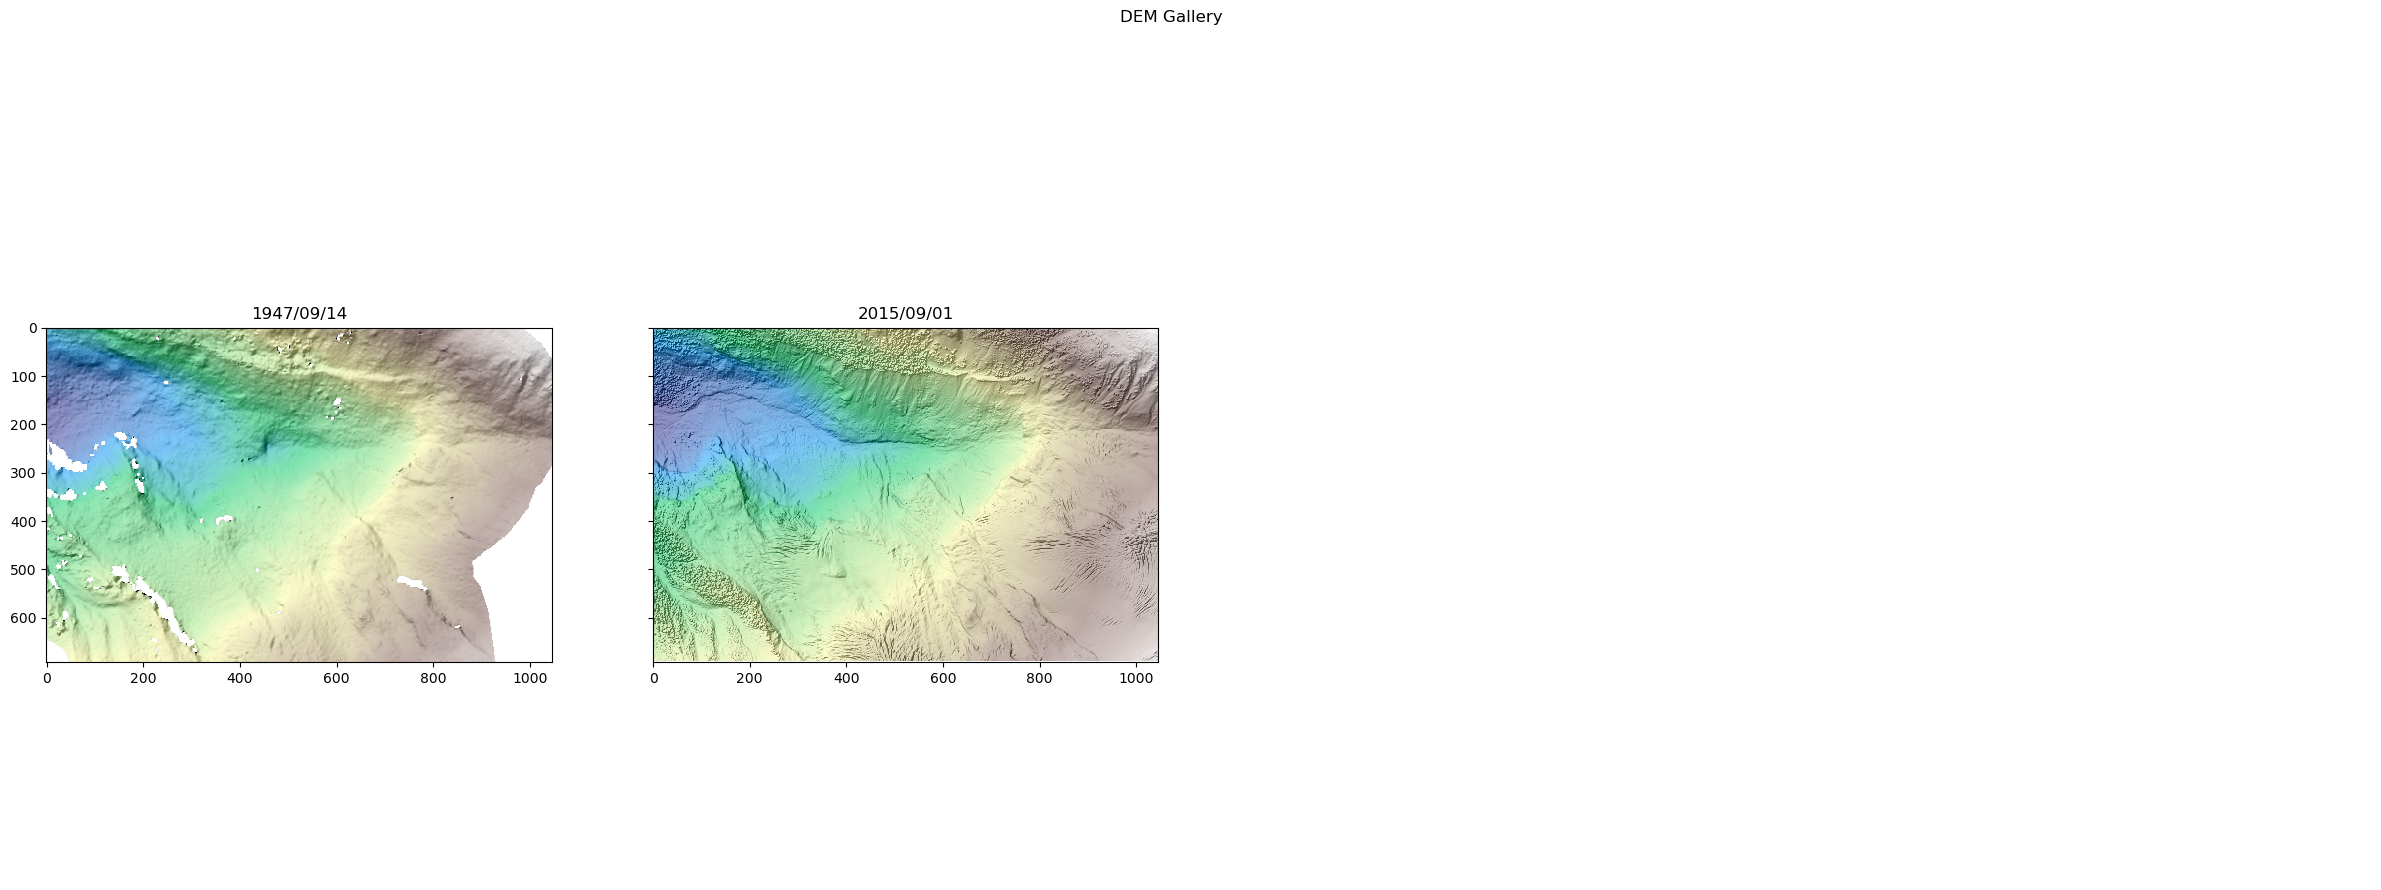

In [15]:
fig, axes = demcollection.plot_dems(hillshade=True, interpolation = "none", figsize=plot_figsize)
plt.suptitle("DEM Gallery")
plt.show()

## Coregister DEMs or Do Not

In [16]:

if TO_COREGISTER:
    for i in range(0, len(demcollection.dems)-1):
        early_dem = demcollection.dems[i]
        late_dem = demcollection.dems[i+1]

        nuth_kaab = xdem.coreg.NuthKaab()
        # Order with the future as reference
        nuth_kaab.fit(late_dem.data, early_dem.data, transform=late_dem.transform, 
            inlier_mask = ~gu.Vector(glaciers_gdf).create_mask(early_dem).squeeze()
        )

        # Apply the transformation to the data (or any other data)
        aligned_ex = nuth_kaab.apply(early_dem.data, transform=early_dem.transform)

        print(F"For DEM {early_dem.datetime}, transform is {nuth_kaab.to_matrix()}")

        early_dem.data = np.expand_dims(aligned_ex, axis=0)

## Subtract DEMs/Create DoDs

In [17]:
# _ = demcollection.subtract_dems_intervalwise()
_ = demcollection.subtract_dems_intervalwise()

## Plot DoDs (pre processing)

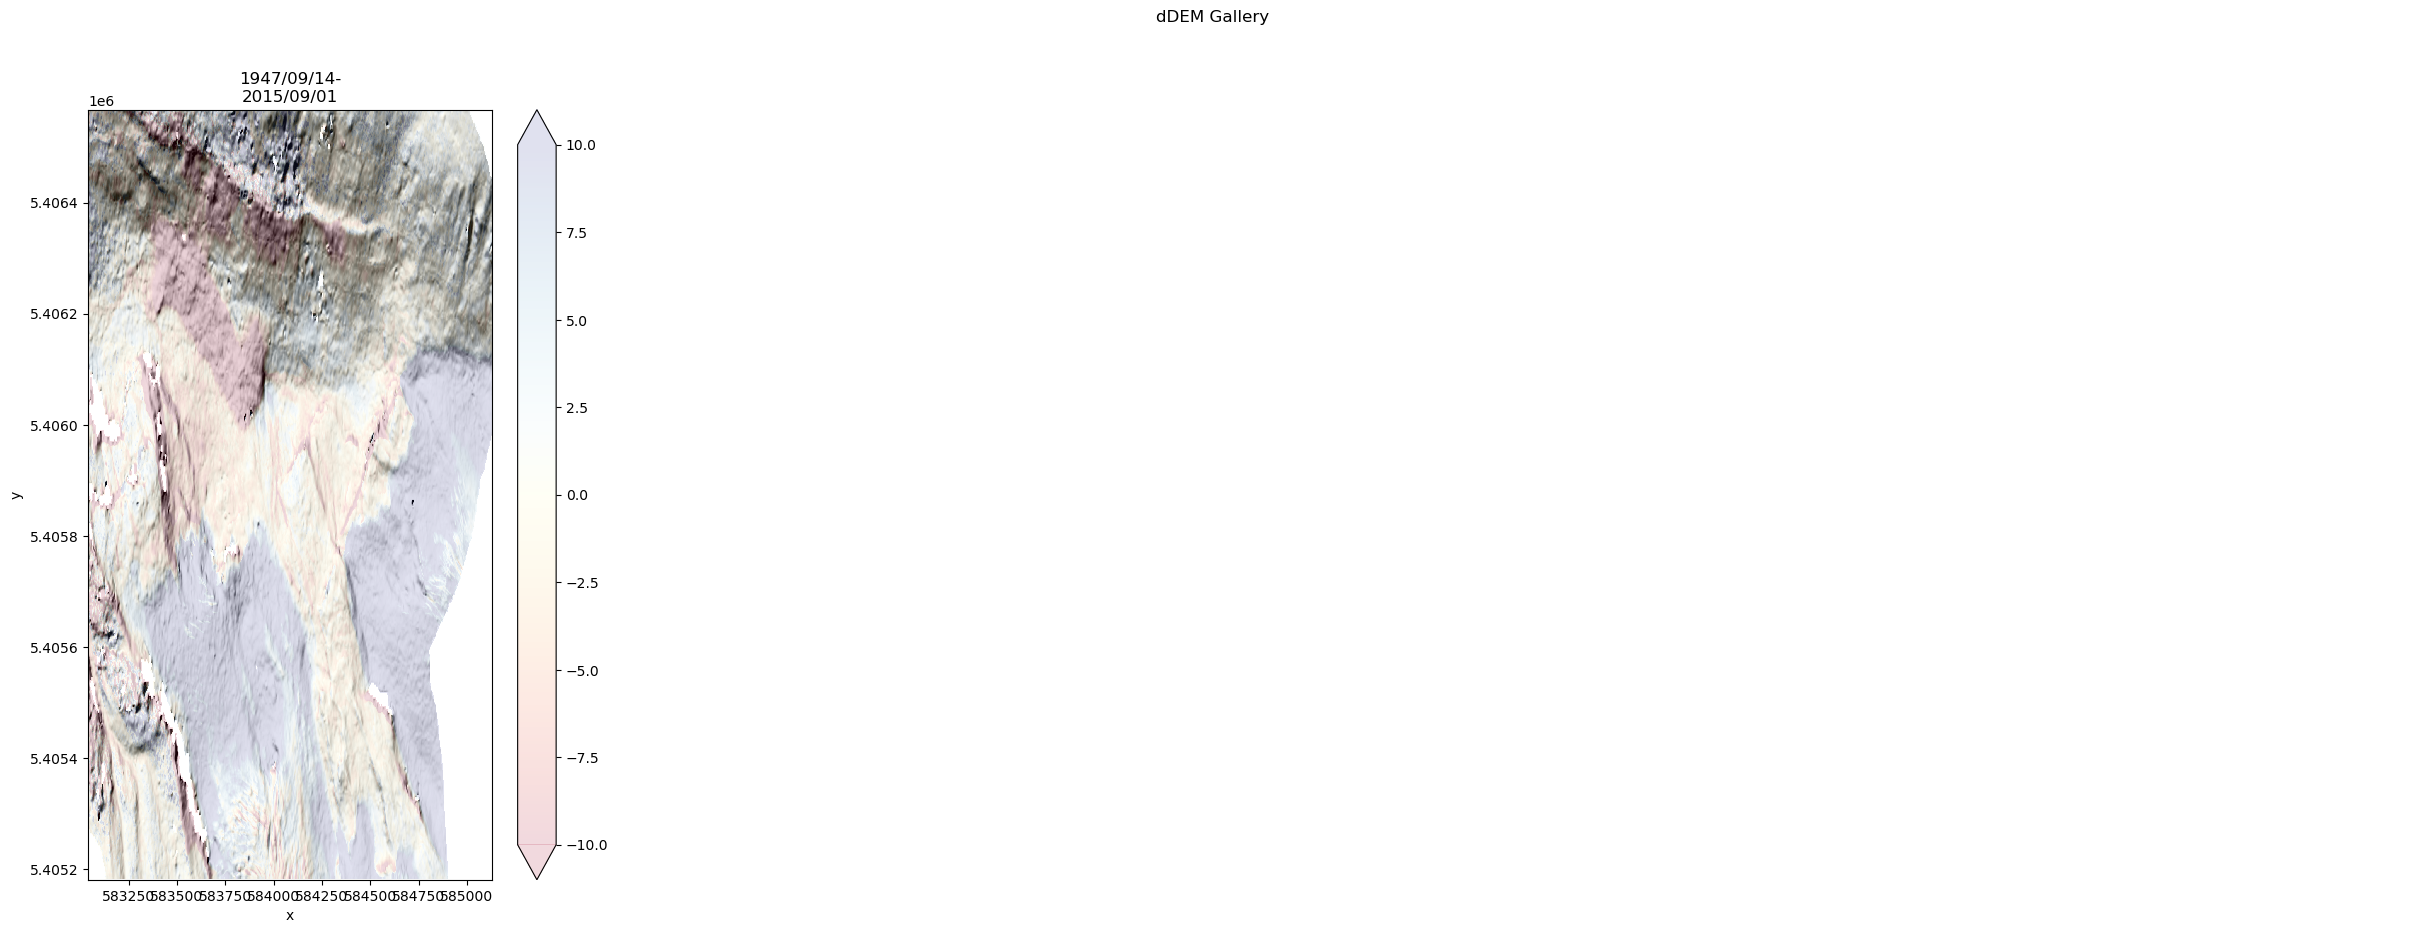

In [18]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=False,
    hillshade=True,
    cmap_alpha=0.15
)
plt.suptitle("dDEM Gallery")
plt.show()

## Mask Glacier Signals

In [19]:
if MASK_GLACIER_SIGNALS:
    for ddem in demcollection.ddems:
        ddem
        relevant_glaciers_gdf = glaciers_gdf[glaciers_gdf['date'].isin([ddem.interval.left, ddem.interval.right])]
        relevant_glaciers_mask = gu.Vector(relevant_glaciers_gdf).create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, relevant_glaciers_mask)

## Filter outliers

In [20]:
if FILTER_OUTLIERS:
    if SIMPLE_FILTER:
        for dh in demcollection.ddems:
            dh.data = np.ma.masked_where(np.abs(dh.data) > simple_filter_threshold, dh.data)
    else:
        for dh in demcollection.ddems:
            all_values_masked = dh.data.copy()
            all_values = all_values_masked.filled(np.nan)
            low = np.nanmedian(all_values) - 4*xdem.spatialstats.nmad(all_values)
            high = np.nanmedian(all_values) + 4*xdem.spatialstats.nmad(all_values)
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print(dh.interval)
            print(low)
            print(high)
            all_values_masked = np.ma.masked_greater(all_values_masked, high)
            all_values_masked = np.ma.masked_less(all_values_masked, low)
            dh.data = all_values_masked
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print()

## Prepare erosion polygons

### Load erosion polygons

In [26]:
hillslope_fluvial_erosion_vector = gu.Vector(erosion_polygon_file)
hillslope_fluvial_erosion_vector.ds = hillslope_fluvial_erosion_vector.ds.to_crs(demcollection.reference_dem.crs)

erosion_vector = gu.Vector(
    pd.concat([
        gu.Vector(gully_data).ds,
        gu.Vector(mwasting_data).ds,
        gu.Vector(debutressing_data).ds
    ])
)

# Remove gully/mass-wasting polygons outside bounds
erosion_vector.ds = erosion_vector.ds[erosion_vector.ds.geometry.apply(lambda g: valley_bounds_vect.ds.geometry.iloc[0].contains(g))]
erosion_vector.ds = pd.concat([erosion_vector.ds, hillslope_fluvial_erosion_vector.ds.to_crs(erosion_vector.ds.crs)])

# Filter datasets
erosion_vector = erosion_vector.query(f"name == '{params['inputs']['valley_name']}'")

In [ ]:
erosion_vector.ds.plot(edgecolor='black', alpha=0.3, column='type')

### Subtract glacier polygons from erosion polygons

Only applies if not EROSION_BY_DATE

For each dDEM time interval, get the two relevant glacier polygons, and subtract them from each erosion polygon, so that each erosion polygon multiplies to become one erosion polygon per time interval

In [ ]:
if not EROSION_BY_DATE:    
    new_erosion_gdf = []

    def subtract_multiple_geoms(polygon, cutting_geometries):
            new_polygon = polygon
            for cutting_geom in cutting_geometries:
                new_polygon = new_polygon.difference(cutting_geom)
            return new_polygon

    for ddem in demcollection.ddems:
        relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
        print(f"Cropping with {len(relevant_glacier_polygons)} glacier polygons.")
        differenced_geoms = erosion_vector.ds.geometry.apply(
            lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
        )
        new_erosion_gdf.append(
            gpd.GeoDataFrame(
                {
                    'geometry': differenced_geoms,
                    'type': erosion_vector.ds['type'],
                    'interval': np.full(
                        len(differenced_geoms),
                        ddem.interval
                    )
                }
            )
        )
    ## also do it for bounding dataset
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right])]
    differenced_geoms = erosion_vector.ds.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf.append(
            gpd.GeoDataFrame(
                {
                    'geometry': differenced_geoms,
                    'type': erosion_vector.ds['type'],
                    'interval': np.full(
                        len(differenced_geoms),
                        pd.Interval(demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right)
                    )
                }
            )
        )
    

    ## also do it for the almost bounding dataset 
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right])]
    differenced_geoms = erosion_vector.ds.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf.append(
            gpd.GeoDataFrame(
                {
                    'geometry': differenced_geoms,
                    'type': erosion_vector.ds['type'],
                    'interval': np.full(
                        len(differenced_geoms),
                        pd.Interval(demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right)
                    )
                }
            )
        )

    
    erosion_vector.ds = pd.concat(new_erosion_gdf)

    #remove any empty geoms
    erosion_vector.ds = erosion_vector.ds[~erosion_vector.ds.geometry.is_empty]

    src = erosion_vector.ds.copy()
    src['interval'] = src['interval'].apply(lambda x: x.left.strftime(strip_time_format))
    src.to_file(erosion_polygons_cropped_by_glaciers_output_file, driver='GeoJSON')

### Split erosion vector into dictionary that organizes erosion polygons by a pd.Interval(start_date, end_Date)

We do this so that DEMCollection.get_dv_series assigns the correct polygons to the correct dDEMs

In [ ]:
if EROSION_BY_DATE:
    # need to create a column "interval" for sorting. Columns 'start_date' and 'end_date' should be in the erosion polygons file if `EROSION_BY_DATE`
    erosion_vector.ds['interval'] = erosion_vector.ds.apply(
        lambda row: pd.Interval(
            pd.Timestamp(datetime.strptime(row['start_date'], strip_time_format)),
            pd.Timestamp(datetime.strptime(row['end_date'], strip_time_format)),
        ), 
        axis=1
    )

start_date_to_gfd = dict(list(erosion_vector.ds.groupby("interval")))
start_date_to_gfd = dict({(key, gu.Vector(gdf)) for key, gdf in start_date_to_gfd.items()})

Plot erosion geoms by date

In [ ]:
grouped_erosion_vector_gdf = erosion_vector.ds.groupby('interval')
for tup in list(grouped_erosion_vector_gdf):
    interval = tup[0]
    gdf = tup[1]
    gdf.plot(alpha=0.25)
    plt.gca().set_title(str(interval))
    plt.show()

### Assign erosion polygons to DEM Collection

In [ ]:
demcollection.outlines = start_date_to_gfd

## Plot DoDs

In [ ]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=True,
    hillshade=True,
    cmap_alpha=0.15
)
plt.suptitle("dDEM Gallery, glacier signals removed")
plt.show()

## Interpolate

In [ ]:
if INTERPOLATE:
    interpolated_ddems = demcollection.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcollection.set_ddem_filled_data()

In [ ]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=True,
    hillshade=True,
    cmap_alpha=0.15
)
plt.suptitle("dDEM Gallery with interpolation, glacier signals removed")
plt.show()

## Mass wasting calculations

## Create gross positive and negative, thresholded datasets

### Define thresholding function
* Make sure to set values equal to 0 instead of actually removing them!!

In [ ]:
from scipy import stats
def threshold_ddem(ddem):
    ddem = ddem.copy()
    sample = ddem.data.compressed()
    datum = uncertainty_df.loc[uncertainty_df['Interval'] == ddem.interval]
    assert len(datum) == 1
    low = datum['90% CI Lower Bound'].iloc[0]
    hi = datum['90% CI Upper Bound'].iloc[0]
    print((low, hi))
    ddem.data[
        np.logical_and(ddem.data>low, ddem.data<hi)
    ] = 0
    
    return ddem

### Create thresholded DEM collection

In [ ]:
threshold_demcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)

threshold_demcollection.ddems_are_intervalwise = True
threshold_demcollection.ddems = [threshold_ddem(ddem) for ddem in demcollection.ddems]
threshold_demcollection.outlines = demcollection.outlines

### Create thresholded positive and negative DEM collections

In [ ]:
def create_positive_and_negative_ddems(ddem):
    pos = ddem.copy()
    neg = ddem.copy()
    pos.data = np.ma.masked_less(pos.data, 0)
    neg.data = np.ma.masked_greater(neg.data, 0)
    return pos, neg
    
threshold_pos_ddems, threshold_neg_ddems = zip(*[create_positive_and_negative_ddems(ddem) for ddem in threshold_demcollection.ddems])


threshold_pos_ddemcollection = xdem.DEMCollection(
    threshold_demcollection.dems,
    threshold_demcollection.timestamps
)
threshold_pos_ddemcollection.ddems_are_intervalwise = True
threshold_pos_ddemcollection.ddems = threshold_pos_ddems
threshold_pos_ddemcollection.outlines = threshold_demcollection.outlines

threshold_neg_ddemcollection = xdem.DEMCollection(
    threshold_demcollection.dems,
    threshold_demcollection.timestamps
)
threshold_neg_ddemcollection.ddems_are_intervalwise = True
threshold_neg_ddemcollection.ddems = threshold_neg_ddems
threshold_neg_ddemcollection.outlines = demcollection.outlines

## Calculations

### Net and gross mass wasted (thresholded)

In [ ]:
unique_types = set()
for k in list(demcollection.outlines.keys()):
    for t in demcollection.outlines[k].ds['type'].unique():
        unique_types.add(t)

def get_dv_series_groupby_process_sums(demcoll):
    dv_df_sep = pd.DataFrame()
    for process in unique_types:
        data = demcoll.get_dv_series(outlines_filter = f"type == '{process}'", return_area=True).reset_index()
        data['type'] = process
        dv_df_sep = dv_df_sep.append(data)
    return dv_df_sep

dv_df_process_sums = get_dv_series_groupby_process_sums(demcollection)
threshold_neg_dv_df_process_sums = get_dv_series_groupby_process_sums(threshold_neg_ddemcollection)
threshold_pos_dv_df_process_sums = get_dv_series_groupby_process_sums(threshold_pos_ddemcollection)

### Add metadata to all the dataframes resulting from the calculations

Maybe this should be added as functionality to DEMCollection?

In [ ]:
def enrich_volume_data(df, pixel_area, pixel_side_length, uncertainty_df):
    """Modify the resulting dataframe of `demcollection.get_dv_series` by 
    adding a bunch of useful data. Calculates volumetric uncertainty as well.

    Args:
        df (_type_): _description_
        pixel_area (_type_): _description_
    """
    df["n_pixels"] = df["area"]/pixel_area

    df["volumetric_uncertainty"] = df.apply(
        lambda row: xdem.spatialstats.volumetric_uncertainty(
            n_pixels = row["n_pixels"],
            pixel_side_length = pixel_side_length,
            rmse = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['RMSE'].iloc[0],
            mean = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Mean'].iloc[0],
            range_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Range'].iloc[0],
            sill_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Sill'].iloc[0],
        ),
        axis=1
    )
    df['start_time'] = df['index'].apply(lambda x: x.left)
    df['end_time'] = df['index'].apply(lambda x: x.right)
    df['time_difference_years'] = df.apply(
        lambda row: round((row['end_time'] - row['start_time']).days/365.25),
        axis=1
    )
    df['Annual Mass Wasted'] = df['volume']/df['time_difference_years']
    #### #### #### #### #### #### #### #### #### #### #### #### 
    #### 
    #### ToDo: Confirm this is the proper calculation:
    #### 
    #### #### #### #### #### #### #### #### #### #### #### #### 
    df["Upper CI"] = (df['volume'] + df['volumetric_uncertainty'])/df['time_difference_years']
    df["Lower CI"] = (df['volume'] - df['volumetric_uncertainty'])/df['time_difference_years']
    df["Average Date"] = df['start_time'] + ((df['end_time'] - df['start_time']) / 2).dt.ceil('D')
    return df

In [ ]:
dv_df_process_sums = enrich_volume_data(
    dv_df_process_sums,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)

threshold_neg_dv_df_process_sums = enrich_volume_data(
    threshold_neg_dv_df_process_sums,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)

threshold_pos_dv_df_process_sums = enrich_volume_data(
    threshold_pos_dv_df_process_sums,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)

### Mark bounding data

In [ ]:
# for df in [
#         dv_df_process_sums,
#         threshold_neg_dv_df_process_sums,
#         threshold_pos_dv_df_process_sums
# ]:
#         df['bounding'] = df.apply(
#         lambda row: 
#                 row['start_time'] == df.start_time.min() and row['end_time'] == df.end_time.max(),
#                 axis = 1
#         )

### Calculate cumulative net volumetric change, by process

#### Remove bounding data for cumulative calculations

In [ ]:
cum_dv_df = dv_df_process_sums.copy().drop(columns='index').reset_index(drop=True)
# cum_dv_df = cum_dv_df[cum_dv_df['bounding'] == False]

In [ ]:

cum_dv_df['volume'] = cum_dv_df['volume'].fillna(0)
cum_dv_df['cumulative volume'] = cum_dv_df.groupby(["type"])['volume'].cumsum().reset_index(drop=True)
cum_dv_df['Lower CI'] = 0
cum_dv_df['Upper CI'] = 0 
cum_dv_df = cum_dv_df.reset_index(drop=True)

In [ ]:
def add_cumulative_uncertainty(df):
    df.loc[len(df) - 1, 'Lower CI'] = df.loc[len(df) - 1, 'cumulative volume'] - np.sqrt(
        (df['volumetric_uncertainty']**2).sum()
    )

    df.loc[len(df) - 1, 'Upper CI'] = df.loc[len(df) - 1, 'cumulative volume'] + np.sqrt(
        (df['volumetric_uncertainty']**2).sum()
    )

    return df

cum_dv_df = pd.concat([
    add_cumulative_uncertainty(cum_dv_df[cum_dv_df['type'] == type].reset_index(drop=True))
    for type in cum_dv_df.groupby("type").groups
])


for process in list(cum_dv_df.groupby(['type' ]).groups):
    cum_dv_df = cum_dv_df.append({
            'cumulative volume': 0,
            'end_time': cum_dv_df.iloc[0]['start_time'],
            'volumetric_uncertainty': 0,
            'type': process
        }, ignore_index=True
    )
cum_dv_df['end_time'] = cum_dv_df['end_time'].apply(pd.Timestamp)

# Plot

## Plot incision rate per process in time

Incision rate is calculated as the gross negative volume change divided by area of measurement.

In [ ]:
src = threshold_neg_dv_df_process_sums.copy()
src['Annual Incision Rate'] = src['Annual Mass Wasted'] / src['area']
# src = src.query("location != 5")
alt.Chart(src.drop(columns='index')).mark_line(
    # strokeWidth = 1.5,
    # stroke="white",
    # opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Incision Rate:Q", 
        title="Annualized incision rate, in m/yr"
    ),
    alt.Facet("type:N"),
    # alt.Color("bounding:N")
).properties(
    # width=300, 
    # height=300
)

## Plot annual volumetric change rate in time

In [ ]:
threshold_neg_dv_df_process_sums['sign'] = 'negative'
threshold_pos_dv_df_process_sums['sign'] = 'positive'

In [ ]:
threshold_neg_dv_df_process_sums['named interval'] = threshold_neg_dv_df_process_sums['index'].apply(str)

## Make erosion positive

In [ ]:
threshold_neg_dv_df_process_sums.columns

In [ ]:
threshold_neg_dv_df_process_sums.head(3)

In [ ]:

alt.Chart(
    threshold_neg_dv_df_process_sums.drop(columns='index')
).mark_bar(

).encode(
    alt.X('named interval:O', axis=alt.Axis(labelAngle=-45)),
    alt.Y("Annual Mass Wasted:Q", scale=alt.Scale(reverse=True))
).properties(width=300, height = 300).facet(
    column='type',
    # column=''
).configure_legend(titleFontSize=20, labelFontSize=16, orient='top').configure_axis(titleFontSize=20, labelFontSize=16, titleFontWeight='normal')

In [ ]:
bars_neg = alt.Chart().transform_filter(
    alt.datum.sign == 'negative'
).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q", title="Annualized rate of volumetric change, in m³/yr"),
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart().transform_filter(
    alt.datum.sign == 'negative'
).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T", title=""),
    alt.Y("Lower CI", title="Annualized rate of volumetric change, in m³/yr"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart().transform_filter(
    alt.datum.sign == 'positive'
).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="blue"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q", title="Annualized rate of volumetric change, in m³/yr"),
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart().transform_filter(
    alt.datum.sign == 'positive'
).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T", title=""),
    alt.Y("Lower CI", title="Annualized rate of volumetric change, in m³/yr"),
    alt.Y2("Upper CI")
)

In [ ]:
alt.layer(
    bars_neg,
    error_bars_neg,
    bars_pos,
    error_bars_pos,
    data = pd.concat([threshold_neg_dv_df_process_sums, threshold_pos_dv_df_process_sums]).drop(columns="index")
).properties(height=150).facet(row="type:N")

## Plot cumulative mass wasted per process

In [ ]:
from datetime import timedelta

In [ ]:
# cum_dv_df.loc[4, 'end_time'] = cum_dv_df.loc[4, 'end_time'] - timedelta(days=300)
# cum_dv_df.loc[9, 'end_time'] = cum_dv_df.loc[9, 'end_time'] - timedelta(days=100)
# cum_dv_df.loc[14, 'end_time'] = cum_dv_df.loc[14, 'end_time'] + timedelta(days=100)
# cum_dv_df.loc[19, 'end_time'] = cum_dv_df.loc[19, 'end_time'] + timedelta(days=300)

# 4,9,14,19

In [ ]:
cum_dv_df.query("type == 'fluvial'")

In [ ]:
areas = alt.Chart(cum_dv_df).transform_filter(
    alt.datum.type != 'hillslope'
).mark_area().encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)


cum_plot = alt.Chart().mark_line(point=True).transform_filter(
    alt.datum.type == 'hillslope'
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    )
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).transform_filter(
    alt.datum.type == 'hillslope'
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
)


alt.layer(
    areas,
    error_bars, 
    cum_plot, 
    data=cum_dv_df
)

In [ ]:
areas = alt.Chart(cum_dv_df).transform_filter(
    alt.datum.type != 'hillslope'
).mark_area().encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)


cum_plot = alt.Chart().mark_line(point=True).transform_filter(
    alt.datum.type == 'hillslope'
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    )
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).transform_filter(
    alt.datum.type == 'hillslope'
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
)


alt.layer(
    areas,
    error_bars, 
    cum_plot, 
    data=cum_dv_df
)

In [ ]:
alt.layer(
    alt.Chart(cum_dv_df.query("type=='glacial debutressing'")).transform_filter(alt.datum.bounding).mark_circle().encode(
        alt.X('end_time'),
        alt.Y("cumulative volume")
    ),
    alt.Chart(cum_dv_df.query("type=='glacial debutressing'")).transform_filter(~alt.datum.bounding).mark_line().encode(
        alt.X('end_time'),
        alt.Y("cumulative volume")
    ),
) 

In [ ]:
cum_plot = alt.Chart().mark_line(point=True).transform_filter(
    alt.datum.type != 'hillslope'
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).transform_filter(
    alt.datum.type != 'hillslope'
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
    alt.Color("type:N")

)

# bounding_points = alt.Chart().mark_circle(size=200).transform_filter(
#     alt.datum.type == 'glacial debutressing'
# ).encode(
#     alt.X("end_time:T"),
#     alt.Y("cumulative volume:Q"),
#     alt.Color("type:N")
# )

alt.layer(
    error_bars, 
    cum_plot,
    # bounding_points.transform_filter(alt.datum.bounding == True), 
    data=cum_dv_df
)

In [ ]:
cum_plot = alt.Chart().mark_line(point=True).transform_filter(
    alt.datum.type != 'hillslope'
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).transform_filter(
    alt.datum.type != 'hillslope'
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
    alt.Color("type:N")

)

# bounding_points = alt.Chart().mark_circle(size=200).transform_filter(
#     alt.datum.type == 'glacial debutressing'
# ).encode(
#     alt.X("end_time:T"),
#     alt.Y("cumulative volume:Q"),
#     alt.Color("type:N")
# )

alt.layer(
    error_bars, 
    cum_plot,
    # bounding_points.transform_filter(alt.datum.bounding == True), 
    data=cum_dv_df
)

In [ ]:
cum_dv_df

In [ ]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
    alt.Color("type:N")

)

alt.layer(
    error_bars, 
    cum_plot, 
    data=cum_dv_df
)

In [ ]:
src = cum_dv_df.copy()
src2 = cum_dv_df.copy()
src2 = src2[~src2.type.isin(['hillslope', 'fluvial'])].groupby(["end_time", "Average Date"]).sum().reset_index()
src2['type'] = 'sum of hillslope processes'
src = pd.concat([src, src2])

cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=2,
    opacity=0.75
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
    alt.Color("type:N")

)

alt.layer(
    error_bars, 
    cum_plot, 
    data=src
)

In [ ]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        title='Cumulative net change, in m³/yr'
    ),
    alt.Color("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=1
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI"),
    alt.Color("type:N")

)

alt.layer(
    error_bars, 
    cum_plot, 
    data=cum_dv_df
).facet("type:N")

## Save dataframes

In [ ]:
dfs = [
    dv_df_process_sums,
    threshold_neg_dv_df_process_sums,
    threshold_pos_dv_df_process_sums,
    cum_dv_df
    
]

names = [
    'dv_df_process_sums_process_bounding',
    'threshold_neg_dv_df_process_sums_process_bounding',
    'threshold_pos_dv_df_process_sums_process_bounding',
    'cum_dv_df_process_bounding', 
]
for df,name in zip(dfs, names):
    df['valley'] = valley_name
    if RUN_LARGER_AREA:
        outdir = os.path.join("outputs", "larger_area", name)
    else:
        outdir = os.path.join("outputs", name)
    outfile = os.path.join(outdir, valley_name + ".pickle")
    os.makedirs(outdir, exist_ok=True)
    print(outfile)
    df.to_pickle(outfile)